# Методы отбора признаков, регуляризации и снижения размерности

## Цели методов

* повышение точности прогноза за счет избавления от шума
* определение списка наиболее значимых факторов

## Исходные данные

In [1]:
import pandas as pd


data = pd.read_csv('statedata.csv', header=0, index_col=0)
target_name = 'Life.Exp'

X = data.drop(target_name, axis=1)
y = data[target_name].values.flatten()

data.head()

,Population,Income,Illiteracy,Life.Exp,Murder,HS.Grad,Frost,Area
AL,3615,3624,2.1,69.05,15.1,41.3,20,50708
AK,365,6315,1.5,69.31,11.3,66.7,152,566432
AZ,2212,4530,1.8,70.55,7.8,58.1,15,113417
AR,2110,3378,1.9,70.66,10.1,39.9,65,51945
CA,21198,5114,1.1,71.71,10.3,62.6,20,156361


## Пошаговая процедура

Действия:
* добавление признаков
* исключение признаков

Критерии:
* p-value
* AIC / BIC
* $R^{2}_{adj}$
* целевые критерии (например, качество прогнозов)


### Класс для линейной регрессии со статистиками

In [2]:
import numpy as np
from scipy.stats import t
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

class AugmentedLinearRegression:
    def __init__(self):
        self.features = None
        self.estimates = None
        self.estimates_cov = None
        self.std_errors = None
        self.t_values = None
        self.p_values = None
        self.r_squared = None
        self.r_squared_adj = None
        self.aic = None
        self.model = LinearRegression()
        self.sigma2_hat = None
        self.df = None
        self.loglike = None
        
    def fit(self, X, y):
        assert isinstance(X, pd.DataFrame)
        m, n = X.shape
        self.df = m - n - 1
        self.model.fit(X, y)
        y_hat = self.model.predict(X)
        self.features = ['__intercept__'] + list(X.columns)
        self.estimates = np.append(self.model.intercept_, self.model.coef_)
        self.sigma2_hat = ((y - y_hat) ** 2).sum() / self.df
        feature_matrix = np.c_[np.ones((m, 1)), X.values]
        self.estimates_cov = (self.sigma2_hat * np.linalg.inv(np.dot(feature_matrix.T, feature_matrix)))
        self.std_errors = np.diagonal(self.estimates_cov) ** 0.5
        self.t_values = self.estimates / self.std_errors
        self.p_values = 2 * (1 - t.cdf(np.abs(self.t_values), df=self.df))
        self.r_squared = r2_score(y_true=y, y_pred=y_hat)
        self.r_squared_adj = 1 - (1 - self.r_squared) * (m - 1) / self.df
        sigma2_loglike = ((y - y_hat) ** 2).mean()
        self.loglike = -m/2 * np.log(2 * np.pi) - m * np.log(sigma2_loglike ** 0.5) - 1/(2 * sigma2_loglike) * ((y - y_hat) ** 2).sum()
        self.aic = 2 * (n + 1) - 2 * self.loglike
        return self
    
    def show_stats(self, n_digits=-1):
        assert self.estimates is not None
        stats_df = np.c_[self.estimates, self.std_errors, self.t_values, self.p_values]
        breaks = [['----'] * 4]
        global_stats = np.zeros((3, 4), np.float64) + np.nan
        global_stats[:, 0] = [self.r_squared, self.r_squared_adj, self.aic]
        if n_digits >= 0:
            stats_df = np.round(stats_df, n_digits)
            global_stats = np.round(global_stats, n_digits)
        stats_df = pd.DataFrame(
            np.r_[stats_df, breaks, global_stats],
            columns=['estimate', 'std_error', 't_value', 'p_value'], 
            index=self.features + ['----', 'R-squared', 'R-squared adjusted', 'AIC']
        )
        
        return stats_df
    
    def predict(self, X):
        return self.model.predict(X)
    
model = AugmentedLinearRegression()
model.fit(X, y)
model.show_stats(4)
    

,estimate,std_error,t_value,p_value
__intercept__,70.9432,1.748,40.5859,0.0
Population,0.0001,0.0,1.7748,0.0832
Income,-0.0,0.0002,-0.0892,0.9293
Illiteracy,0.0338,0.3663,0.0923,0.9269
Murder,-0.3011,0.0466,-6.459,0.0
HS.Grad,0.0489,0.0233,2.0979,0.042
Frost,-0.0057,0.0031,-1.8246,0.0752
Area,-0.0,0.0,-0.0443,0.9649
----,----,----,----,----
R-squared,0.7362,nan,nan,nan


### Пошаговое исключение регрессоров

In [3]:
X = data.drop(target_name, axis=1)
model = AugmentedLinearRegression()
model.fit(X, y)

r2_bench = 0

while model.r_squared_adj > r2_bench:  # целевой критерий - R^2 adjusted
    X_bench = X.copy()
    r2_bench = model.r_squared_adj
    X.drop(X.columns[model.p_values[1:].argmax()], axis=1, inplace=True)  # убираем из таблицы признаков фактор с наибольшим p-value
    model.fit(X, y)
    
model.fit(X_bench, y)
model.show_stats(4)

,estimate,std_error,t_value,p_value
__intercept__,71.0271,0.9529,74.5415,0.0
Population,0.0001,0.0,1.996,0.052
Murder,-0.3001,0.0366,-8.1987,0.0
HS.Grad,0.0466,0.0148,3.1417,0.003
Frost,-0.0059,0.0024,-2.455,0.018
----,----,----,----,----
R-squared,0.736,nan,nan,nan
R-squared adjusted,0.7126,nan,nan,nan
AIC,113.7326,nan,nan,nan


### Пошаговое добавление / исключение регрессоров

In [4]:
from copy import deepcopy

features = [col for col in data.columns if col != target_name]  # список всех признаков
n_features = len(features)

in_model_bench = [False] * n_features  # индикатор того, включен ли признак в модель
r2_bench = 0
done = False  # будем добавлять / исключать признаки, пока растет R^2 adjusted

model = AugmentedLinearRegression()

while not done:
    
    r2 = np.zeros(n_features, np.float64)
    
    for j in range(n_features):
        in_model = deepcopy(in_model_bench)
        if in_model[j] and sum(in_model):
            continue  # не можем убрать единственный фактор
        in_model[j] = not in_model[j]  # пробуем добавить новый признак в модель или убрать старый
        X = data.drop(target_name, axis=1).loc[:, in_model]
        model.fit(X, y)
        r2[j] = model.r_squared_adj

    k = r2.argmax()
    if r2[k] > r2_bench:  # если удалось найти модель с лучшим R^2 adjusted
        in_model_bench[k] = not in_model_bench[k]  # обновляем список факторов
        r2_bench = r2[k]
    else:
        done = True
        
X = data.drop(target_name, axis=1).loc[:, in_model_bench]
model.fit(X, y)
model.show_stats(4)

,estimate,std_error,t_value,p_value
__intercept__,71.0271,0.9529,74.5415,0.0
Population,0.0001,0.0,1.996,0.052
Murder,-0.3001,0.0366,-8.1987,0.0
HS.Grad,0.0466,0.0148,3.1417,0.003
Frost,-0.0059,0.0024,-2.455,0.018
----,----,----,----,----
R-squared,0.736,nan,nan,nan
R-squared adjusted,0.7126,nan,nan,nan
AIC,113.7326,nan,nan,nan


### Недостатки пошаговой процедуры

* из-за последовательного характера добавления и исключения рассматриваются не все возможные комбинации признаков
* нет четкого правила остановки в случае рассогласования критериев

## Регуляризация

### Ridge Regression (регуляризация L2)

$ Loss = \sum_{i=1}^m (y_i - \beta_0 - \sum_{j=1}^n x_{i,j}\beta_j) ^ 2 + \alpha \sum_{j=1}^n \beta_j^2 $

$ \hat \beta_{ridge} = (X'X + \alpha^{*} I) ^ {-1} X' \vec y $, где $ \alpha^{*} $ — вектор $ (0, \alpha) $, $I$ — единичная матрица.

$\alpha$ — параметр регуляризации. Чем он больше, тем выше штраф за сложность модели.

#### Иллюстрация изменения значений коэффициентов под действием регуляризации

In [5]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

X = data.drop(target_name, axis=1)
m, n = X.shape
columns = list(X.columns)

# нормировка, чтобы значения коэффициентов были сопоставимы
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

n_models = 1000
alphas = np.logspace(-2, 4, n_models) # сетка значений параметра регуляризации
coefs = np.zeros((n_models, n + 1), np.float64)

for i in range(n_models):
    ridge = Ridge(alpha=alphas[i])
    ridge.fit(X, y)
    coefs[i, 0] = deepcopy(ridge.intercept_)
    coefs[i, 1:] = deepcopy(ridge.coef_)

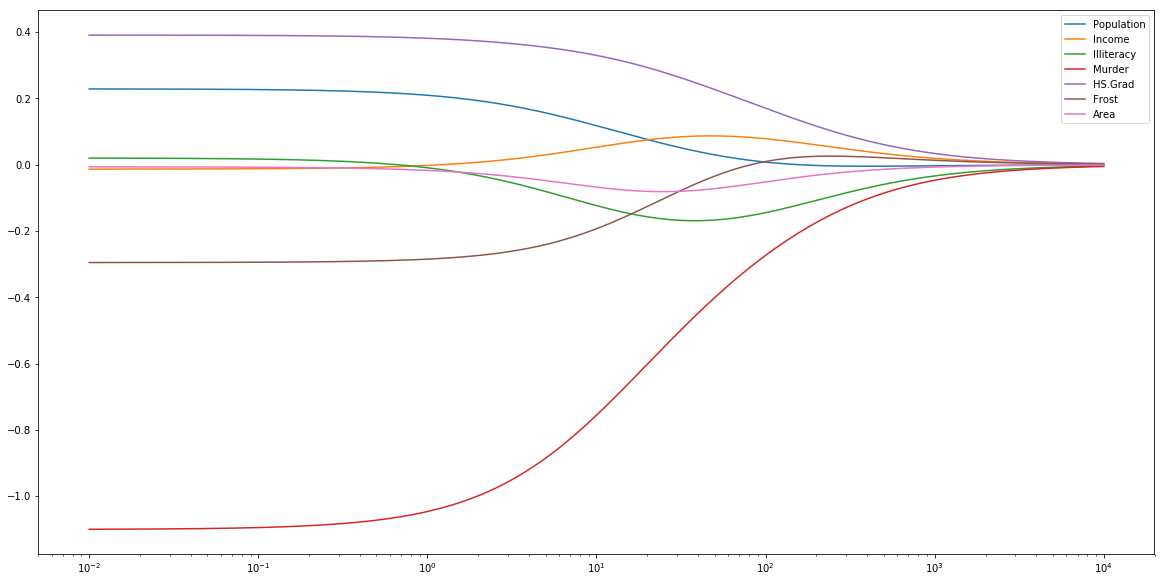

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
for j in range(n):
    ax.semilogx(alphas, coefs[:, j + 1], '-', label=columns[j])
plt.legend()
plt.show()

### Lasso Regression (регуляризация L1)

$ Loss = \sum_{i=1}^m (y_i - \beta_0 - \sum_{j=1}^n x_{i,j}\beta_j) ^ 2 + \alpha \sum_{j=1}^n |\beta_j| $

$\alpha$ — параметр регуляризации. Чем он больше, тем выше штраф за сложность модели.

Для коэффициентов $\hat \beta_{lasso}$ нет аналитической формулы. Задача оптимизации решается численно.

#### Иллюстрация изменения значений коэффициентов под действием регуляризации

In [7]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X = data.drop(target_name, axis=1)
m, n = X.shape
columns = list(X.columns)

# нормировка, чтобы значения коэффициентов были сопоставимы
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

n_models = 1000
alphas = np.logspace(-4, 1, n_models) # сетка значений параметра регуляризации
coefs = np.zeros((n_models, n + 1), np.float64)

for i in range(n_models):
    ridge = Lasso(alpha=alphas[i])
    ridge.fit(X, y)
    coefs[i, 0] = deepcopy(ridge.intercept_)
    coefs[i, 1:] = deepcopy(ridge.coef_)

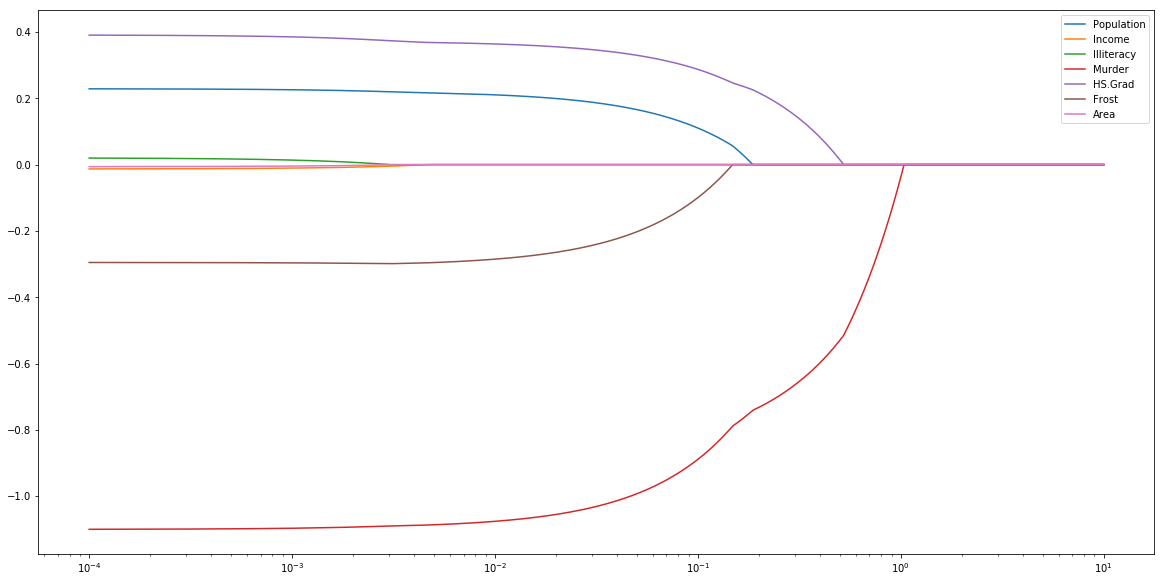

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
for j in range(n):
    ax.semilogx(alphas, coefs[:, j + 1], '-', label=columns[j])
plt.legend()
plt.show()

## Снижение размерности: метод главных компонент

Идея состоит в замене исходной матрицы регрессоров X на матрицу их линейных комбинаций Z. Каждый из новых признаков объясняет некоторую часть изменчивости Х, так что мы можем включать в модель только самые информативные из новых признаков.

$Z_{pc}$ — матрица главных компонент $X$:

$Z_{pc} = XV$, где $V$ — матрица собственных векторов $X'X$ (по столбцам)

Новая матрица регрессоров $Z$ составляется из $p$ столбцов матрицы $Z_{pc}$

$\hat \beta_{pcr} = (Z'Z)^{-1}Z'y$ — оценки коэффициентов регрессии главных компонент

Порядок главных компонент $Z_{pc}$ отражает степень их вляиния на дисперсию признаков, но их влияние на дисперсию целевой переменной может быть иным. Поэтому бывает полезным переставить столбцы $Z_{pc}$ в соответствии с их влиянием на $y$.

In [9]:
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

X = data.drop(target_name, axis=1)
m, n = X.shape

pca = PCA().fit(X)
Z = pca.transform(X)

# проверим, насколько каждая из главных компонент объясняет дисперсию у
r2 = np.zeros(n, np.float64)
lr = LinearRegression()
for j in range(n):
    lr.fit(Z[:, j].reshape(-1, 1), y)
    r2[j] = r2_score(y_true=y, y_pred=lr.predict(Z[:, j].reshape(-1, 1)))
    
r2

array([1.15194807e-02, 4.11429008e-03, 1.86465522e-01, 1.79261872e-02,
       2.73228541e-01, 2.42793608e-01, 1.08639375e-04])

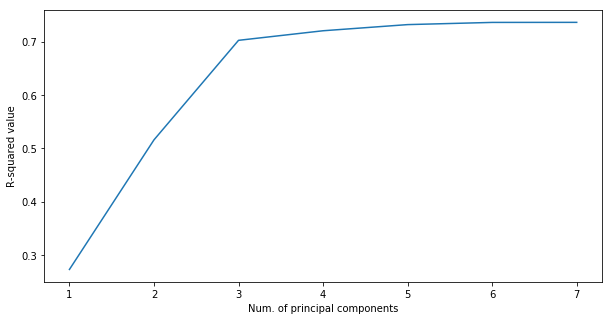

In [10]:
# переставим стобцы Z в соответствии с их вкладом в модель
Z = Z[:, r2.argsort()[::-1]]
r2_cum = np.zeros(n, np.float64)

for j in range(n):
    z = Z[:, :j + 1]
    if len(z.shape) == 1: z = z.reshape(-1, 1)
    lr.fit(z, y)
    r2_cum[j] = r2_score(y_true=y, y_pred=lr.predict(z))

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(np.arange(n) + 1, r2_cum, '-')
plt.xlabel('Num. of principal components')
plt.ylabel('R-squared value')
plt.show()

## Библиотека для определения значимости факторов в модели "черного ящика"

In [11]:
import shap

X = data.drop(target_name, axis=1)

model = AugmentedLinearRegression()
model.fit(X, y)

explainer = shap.KernelExplainer(model.predict, X)
shap_values = explainer.shap_values(X)
print("Shap values shape:", shap_values.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.26it/s]


Shap values shape: (50, 7)


Если мы сложим значения _shap values_ по столбцам, то получим прогноз целевой переменной с точностью до константы. Таким образом, величины _shap values_ представляют собой вклады факторов в прогнозное значение целевой переменной.

Оценить значимость признаков можно, например, найдя их средний абсолютный вклад по всем наблюдениям.

In [12]:
model.predict(X) - shap_values.sum(1)

array([70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786,
       70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786,
       70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786,
       70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786,
       70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786,
       70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786,
       70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786, 70.8786,
       70.8786])

In [13]:
features_importance = np.abs(shap_values).sum(0)
features_importance /= features_importance.sum()

pd.DataFrame(features_importance.reshape(-1, 1), index=X.columns, columns=['relative_importance'])

,relative_importance
Population,0.094122
Income,0.006200
Illiteracy,0.010071
Murder,0.561110
HS.Grad,0.183125
Frost,0.143446
Area,0.001926
